In [1]:
import numpy as np
from PIL import Image
import cv2
import random
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist,squareform
import networkx as nx
import random
from sklearn.neighbors import NearestNeighbors

In [2]:
def knn_graph(matrix, k=5):
    G = nx.Graph()
    nbrs = NearestNeighbors(n_neighbors=k).fit(matrix)
    distances, indices = nbrs.kneighbors(matrix)
    
    for i in range(len(matrix)):
        G.add_node(i, pos=(matrix[i, 0], matrix[i, 1]))
        for j in indices[i]:
            if i != j:
                G.add_edge(i, j, weight=distances[i][np.where(indices[i] == j)[0][0]])
    
    return G

def plot_knn_graph(G,highlighted_nodes,polygon_mask):
    
    # Create a color map for nodes
    highlight_color = "#FF4500"
    node_colors = [highlight_color if node in highlighted_nodes else 'lightblue' for node in G.nodes()]
    #if pos == None:    
    pos = nx.get_node_attributes(G, 'pos')
    # Draw the graph
    fig,ax = plt.subplots(figsize=(8, 8))
    ax.imshow(polygon_mask, cmap='gray', alpha=0.3)
    nx.draw(G, pos, with_labels=False, node_size=100, node_color=node_colors, edge_color='gray', alpha=0.6,ax = ax)
    return fig,ax
    
def plot_scatter(pos,highlighted_nodes,polygon_mask):
    
    # Create a color map for nodes
    highlight_color = "#FF4500"
    node_colors = [highlight_color if i in highlighted_nodes else 'lightblue' for i in np.arange(1000)]
    #if pos == None:    
    #pos = nx.get_node_attributes(G, 'pos')
    # Draw the graph
    fig,ax = plt.subplots(figsize=(8, 8))
    ax.imshow(polygon_mask, cmap='gray', alpha=0.3)
    ax.scatter(pos[:,0],pos[:,1],s = 50,c = node_colors)
    #nx.draw(G, pos, with_labels=False, node_size=100, node_color=node_colors, edge_color='gray', alpha=0.6,ax = ax)
    return fig,ax


    #nx.draw(G, pos, with_labels=False, node_size=100, node_color='lightblue', edge_color='gray', alpha=0.6)
    #plt.show()

def plot_knn_graph_pos(G,highlighted_nodes,pos):
    #pos = nx.get_node_attributes(G, 'pos')
    highlight_color = "#FF4500"
    node_colors = [highlight_color if node in highlighted_nodes else 'lightblue' for node in G.nodes()]
    fig,ax = plt.subplots(figsize=(8, 8))
    nx.draw(G, pos, with_labels=False, node_size=100, node_color=node_colors, edge_color='gray', alpha=0.6,ax = ax)
    return fig,ax
    
def compute_kernel_matrix(X,k):
    D = squareform(pdist(X))
    D_s = np.argsort(D,axis=1)
    sig = np.median(D_s[:,(k+1)])
    #K = np.exp(-D**2/np.outer(sig,sig))    
    K = np.exp(-D**2/sig**2)    
    return K

def compute_laplacian(K):
    D_inv = np.diag(np.sum(K,axis = 1)**(-0.5))
    L = D_inv@K@D_inv
    return L

def compute_leading_eigenvectors(L,d):
    lam,v = np.linalg.eigh(L)
    sort_idx = np.argsort(lam)[::-1]
    lam = lam[sort_idx]
    v = v[:,sort_idx]
    return lam[:d],v[:,:d]

    

In [3]:

def load_image(image_path):
    image = cv2.imread(image_path)
    image = cv2.resize(image, (image.shape[1] // 4, image.shape[0] // 4))  # Reduce size by half
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    return image, hsv

def detect_shapes(image):
    polygon_mask = np.zeros(image.shape[:2], dtype=np.uint8)
    rectangles = []
    circles = []
    
    # Define color ranges
    black_lower = np.array([0, 0, 0])
    black_upper = np.array([180, 255, 50])
    blue_lower = np.array([100, 150, 50])
    blue_upper = np.array([140, 255, 255])
    green_lower = np.array([40, 50, 50])
    green_upper = np.array([90, 255, 255])
    
    # Detect black polygon
    black_mask = cv2.inRange(image, black_lower, black_upper)
    contours, _ = cv2.findContours(black_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    for contour in contours:
        cv2.drawContours(polygon_mask, [contour], -1, 255, thickness=cv2.FILLED)
    
    # Detect blue rectangles
    blue_mask = cv2.inRange(image, blue_lower, blue_upper)
    contours, _ = cv2.findContours(blue_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        rectangles.append((x, y, w, h))
    
    # Detect green circles
    green_mask = cv2.inRange(image, green_lower, green_upper)
    contours, _ = cv2.findContours(green_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    for contour in contours:
        (x, y), radius = cv2.minEnclosingCircle(contour)
        circles.append((int(x), int(y), int(radius)))
    
    return polygon_mask, rectangles, circles


def generate_random_points(mask, num_points=1000):
    points = []
    h, w = mask.shape
    while len(points) < num_points:
        x, y = random.randint(0, w-1), random.randint(0, h-1)
        if mask[y, x] == 255:
            points.append((x, y))
    return points

def build_graph(mask, rectangles):
    G = nx.grid_2d_graph(mask.shape[0], mask.shape[1])
    for x, y, w, h in rectangles:
        for i in range(x, x+w):
            for j in range(y, y+h):
                if (j, i) in G:                    
                    G.remove_node((j, i))
    return G

def compute_shortest_paths(G, points, circles):
    distance_matrix = np.zeros((len(points), len(circles)))
    for i, (px, py) in enumerate(points):
        if (i==10):
            print(i)
        for j, (cx, cy, _) in enumerate(circles):
            try:
                path_length = nx.shortest_path_length(G, (py, px), (cy, cx))
            except nx.NetworkXNoPath:
                path_length = float('inf')
            distance_matrix[i, j] = path_length
    return distance_matrix


In [4]:
# Example usage:
image_path = 'C:\\Users\\Noa\\Documents\\Thesis\\data\\floor_plan_c.png'

image, gray = load_image(image_path)
print(image.shape)
polygon_mask, rectangles, circles = detect_shapes(gray)
print('generating points')
random_points = generate_random_points(polygon_mask)

#print('Computing graph')
#G = build_graph(polygon_mask, rectangles)
#distance_matrix = compute_shortest_paths(G, random_points, circles)

#print(distance_matrix)


(129, 210, 3)
generating points


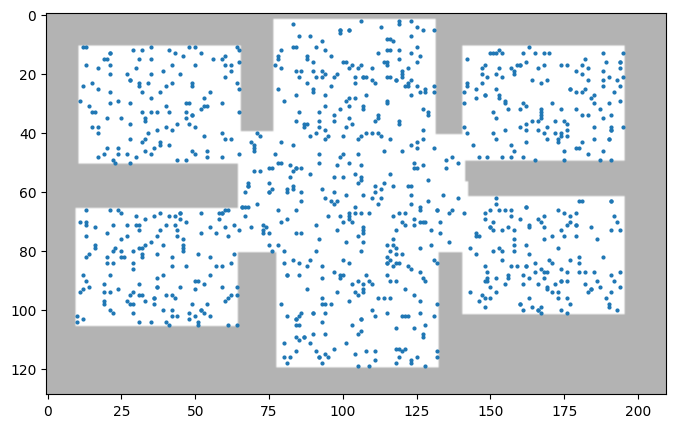

In [5]:
random_points = np.array(random_points)
fig,ax = plt.subplots(figsize=(8, 8))
ax.imshow(polygon_mask, cmap='gray', alpha=0.3)
ax.scatter(random_points[:,0],random_points[:,1],s = 4)
#print(random_points.shape)
    

In [6]:
G = build_graph(polygon_mask, rectangles)
distance_matrix = compute_shortest_paths(G, random_points, circles)

10


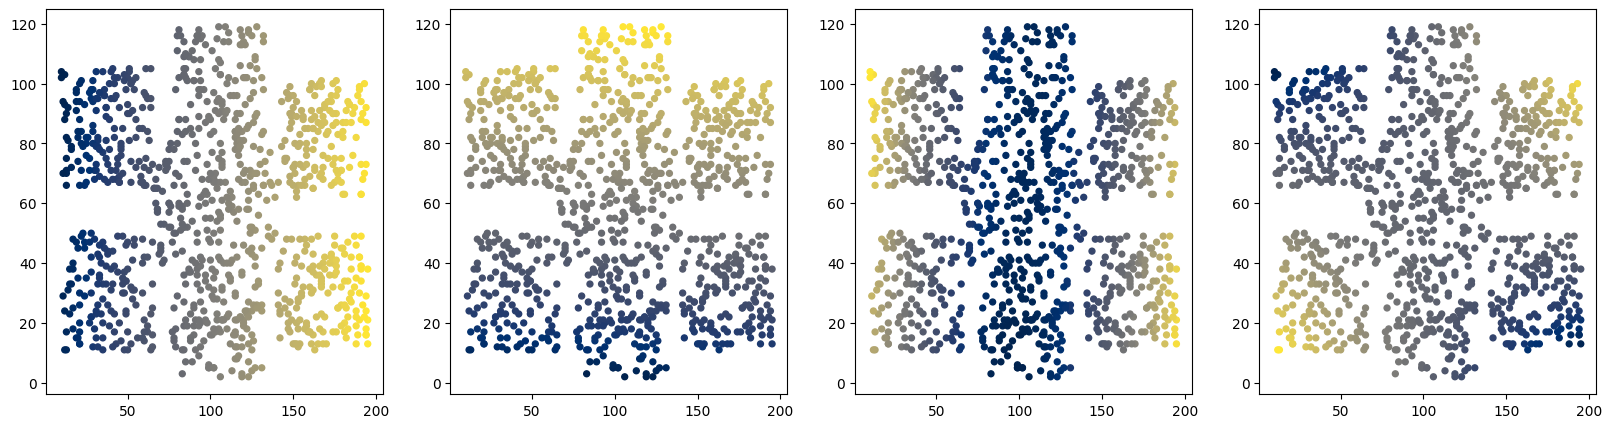

In [7]:
K_p = compute_kernel_matrix(np.array(random_points),k = 7)
L_p = compute_laplacian(K_p)
#D_s = np.argsort(D,axis=1)
#    sig = D_s[:,(k+1)]
#    K = np.exp(-D**2/np.outer(sig,sig))
lam,v_p = compute_leading_eigenvectors(L_p,30)
fig,axs = plt.subplots(1,4,figsize = (20,5))
for i,ax in enumerate(axs.flatten()):
    ax.scatter(random_points[:,0],random_points[:,1],c = v_p[:,i+1],s = 18,cmap = 'cividis')
fig.savefig('eigenvectors_location.png')


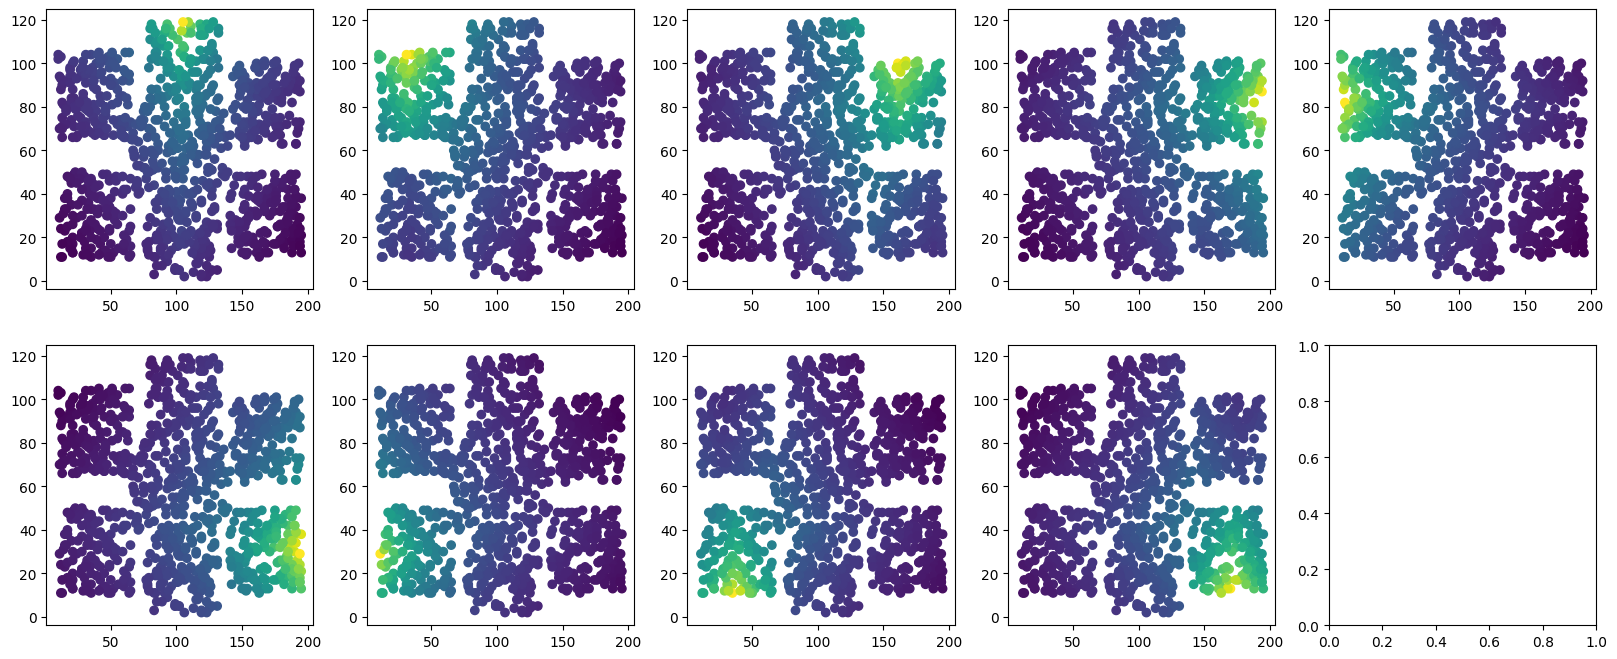

In [ ]:
random_points = np.array(random_points)
fig,axs = plt.subplots(2,5,figsize = (20,8))
for i,ax in enumerate(axs.flatten()[:9]):
    ax.scatter(random_points[:,0],random_points[:,1],c = np.log(1/(distance_matrix[:,i]**2)))

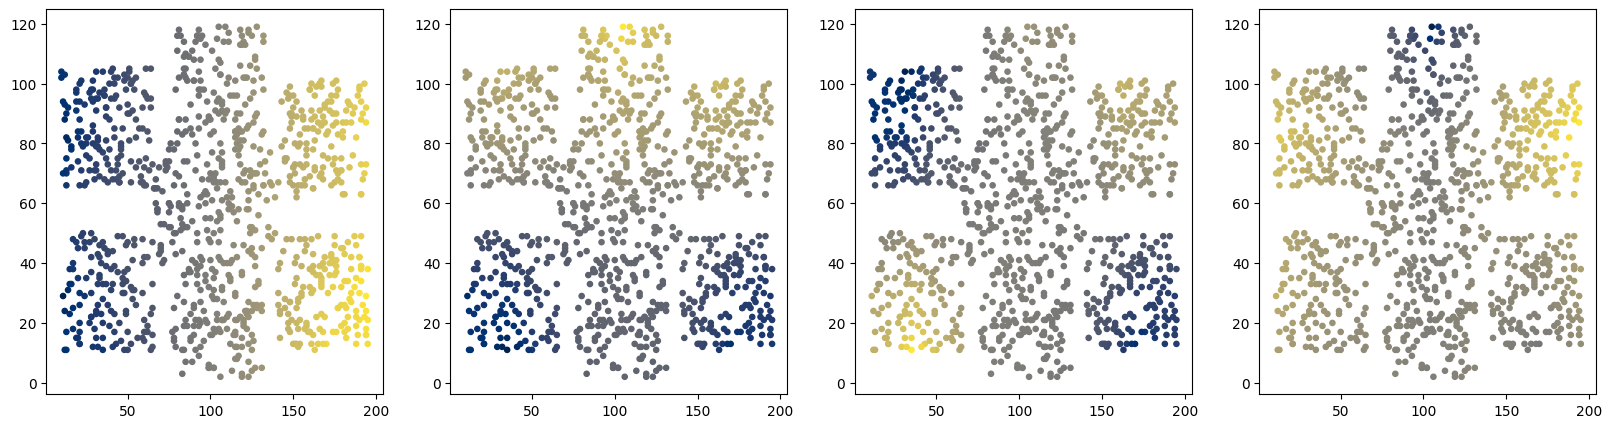

In [ ]:
# signals 

K_sig = compute_kernel_matrix(np.log(1/(distance_matrix**2)),k = 7)
L_sig = compute_laplacian(K_sig)
#D_s = np.argsort(D,axis=1)
#    sig = D_s[:,(k+1)]
#    K = np.exp(-D**2/np.outer(sig,sig))
lam,v_sig = compute_leading_eigenvectors(L_sig,30) #Signals Embedding
fig,axs = plt.subplots(1,4,figsize = (20,5))
for i,ax in enumerate(axs.flatten()):
    ax.scatter(random_points[:,0],random_points[:,1],c = v_sig[:,i+1],s = 14,cmap = 'cividis')
fig.savefig('eigenvectors_signals.png')

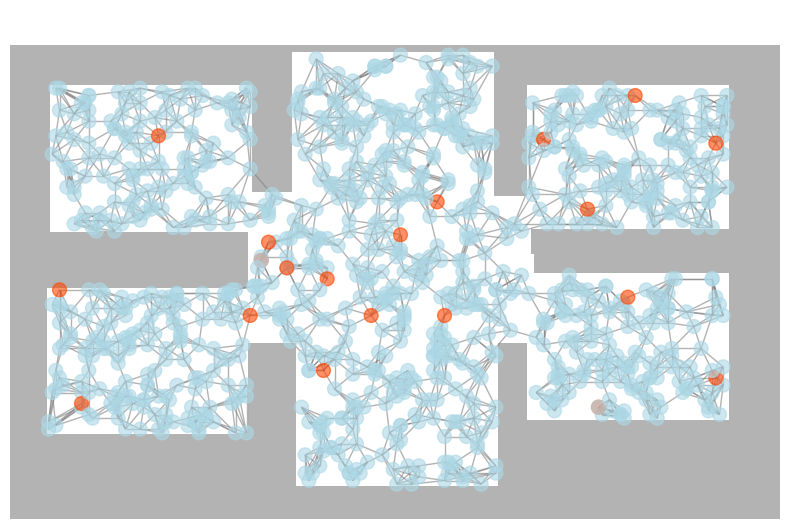

In [10]:
G_p = knn_graph(random_points,7)
highlighted = np.random.choice(np.arange(1000),size = 20,replace=False)
fig,ax = plot_knn_graph(G_p,highlighted,polygon_mask)
#ax.imshow(polygon_mask)
fig.tight_layout()
fig.savefig('graph_points.png')

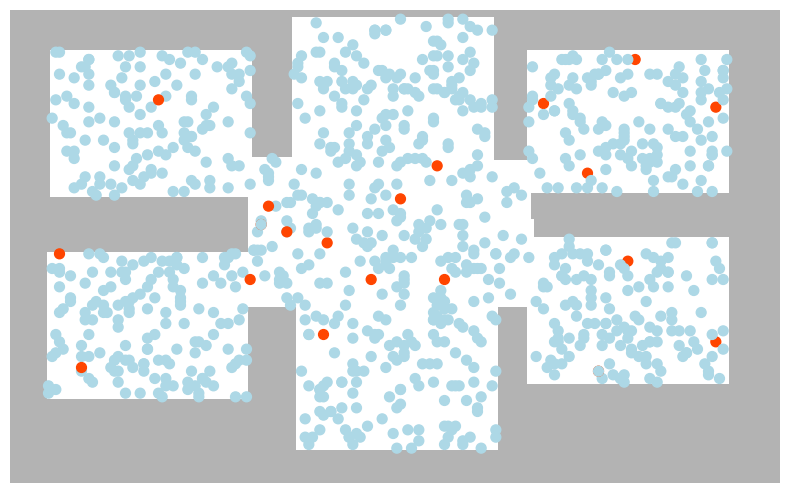

In [11]:
fig,ax = plot_scatter(random_points,highlighted,polygon_mask)
plt.axis('off')
fig.tight_layout()
fig.savefig('points_scatter.png')

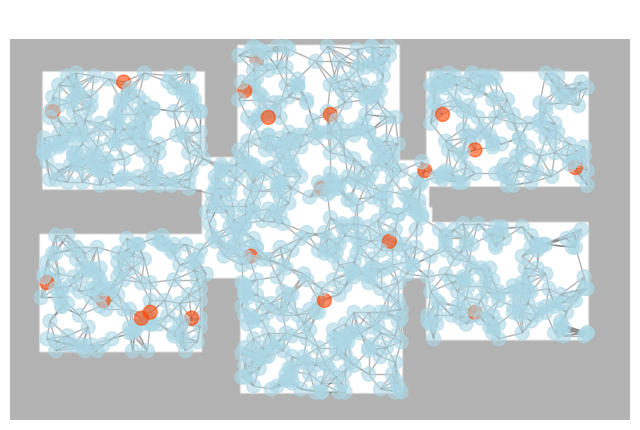

In [17]:
import matplotlib.colors as mcolors
fig,ax = plot_knn_graph(G_p,highlighted,polygon_mask)

#cmap = mcolors.ListedColormap([
#    (1, 1, 1, 1),    # White (Opaque)
#    (0.7, 0.7, 0.7, 0.3)  # Light Gray (50% Transparent)
#])
#bounds = [0, 0.5, 1]  # Define boundaries for 0 and 1
#norm = mcolors.BoundaryNorm(bounds, cmap.N)  # Normalize values

# Plot the binary image with imshow
#ax.imshow(polygon_mask, cmap=cmap, norm=norm)
#plt.axis('off')

In [133]:
polygon_mask

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

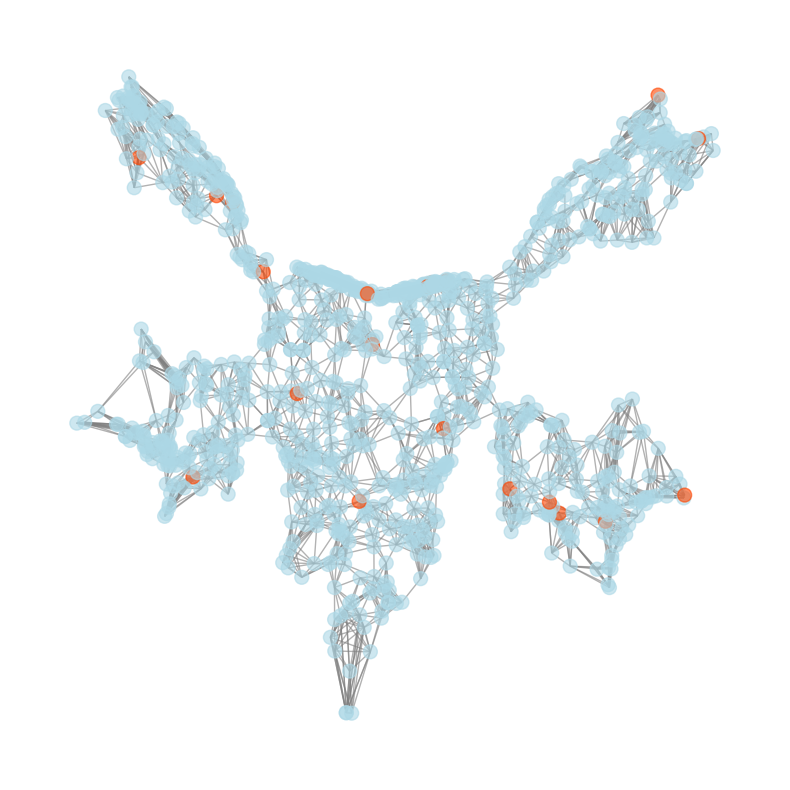

In [18]:
S = np.log(1/(distance_matrix**2))
G_sig = knn_graph(S,k = 10)
fig,ax = plot_knn_graph_pos(G_sig,highlighted,pos = v_sig[:,1:3])
#ax.plot(po)
fig.tight_layout()
fig.savefig('signals_graph.png')